In [1]:
using AlgebraicPetri
using AlgebraicRewriting
using Catlab.Present, Catlab.Theories, Catlab.CategoricalAlgebra
using Catlab.CategoricalAlgebra.CSetDataStructures: struct_acset
const hom = AlgebraicRewriting.homomorphism;

We can convert any petri net into a ABM, giving it the "token-passing"
semantics, by converting each transition into a rewrite rule.


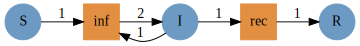

In [2]:
sir_petri = LabelledPetriNet([:S,:I,:R],
                              :inf=>((:S,:I)=>(:I,:I)),
                              :rec=>(:I=>:R))
Graph(sir_petri)

In [3]:
"""
The states of a Petri net induce a discrete schema for a C-Set
"""
function petri_to_cset_type(p::LabelledPetriNet, name::Symbol=:Discrete)::Type
  pres = Presentation(FreeSchema)
  [add_generator!(pres, Ob(FreeSchema, l)) for l in p[:sname]]
  expr = struct_acset(name, StructACSet, pres)
  eval(expr)
  return eval(name)
end

SIR = petri_to_cset_type(sir_petri, :SIR_model)

@acset SIR begin S=3; I=2; R=0 end # Model w/ 3 susceptible, 2 infected

SIR_model with elements S = 1:3, I = 1:2, R = 1:0

In [4]:

"""
The rewrite rule matches for the inputs to the transition, deletes them, and
adds the outputs to the transition.
"""
function transition_to_rw_rule(p::LabelledPetriNet, t::Int)
  Rule(map([(:it,:is), (:ot,:os)]) do (getIO, getState)
    cset = petri_to_cset_type(p)()
    [add_part!(cset, x) for x in p[incident(p, 1, getIO), [getState,:sname]]]
    return create(cset) # interface I is an empty C-Set
  end...)
end

rw = transition_to_rw_rule(sir_petri, 1)
codom(rw.L) # C-Set with S=1 and I=1
codom(rw.R); # C-Set with I=2


LoadError: MethodError: no method matching Discrete()
The applicable method may be too new: running in world age 31420, while current world is 31421.
[0mClosest candidates are:
[0m  Discrete() at ~/.julia/packages/Catlab/9oZsA/src/categorical_algebra/CSetDataStructures.jl:75 (method too new to be called from this world context.)
[0m  (::Type{T})([91m::ACSet[39m, [91m::AbstractDict[39m, [91m::AbstractDict[39m) where T<:ACSet at ~/.julia/packages/Catlab/9oZsA/src/categorical_algebra/DataMigrations.jl:157
[0m  (::Type{T})([91m::ACSet[39m, [91m::Functor{Dom, Codom} where {Dom<:(Category{Ob, Hom, Catlab.CategoricalAlgebra.FinCats.FinCatSize} where {Ob, Hom}), Codom<:(Category{Ob, Hom, Catlab.CategoricalAlgebra.FinCats.FinCatSize} where {Ob, Hom})}[39m) where T<:ACSet at ~/.julia/packages/Catlab/9oZsA/src/categorical_algebra/DataMigrations.jl:152
[0m  ...

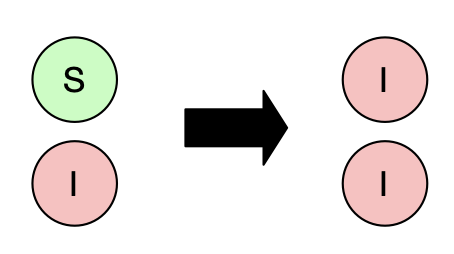

We can repeat the above but this time include a graph that the tokens live on.
We assume the tokens move around randomly and interact only when living on the
same vertex


In [5]:
using Catlab.Graphs: SchGraph

loc(s::Symbol) = Symbol("$(s)_loc")

function petri_to_cset_type_gr(p::LabelledPetriNet, name::Symbol=:PGraph)::Type
  pres = copy(SchGraph)
  isempty(p[:sname] ∩ [:V,:E] ) || error("V and E are reserved")
  for l in p[:sname]
    add_generator!(pres, Hom(loc(l),
                              add_generator!(pres, Ob(FreeSchema, l)),
                              pres.generators[:Ob][1]))
  end
  expr = struct_acset(name, StructACSet, pres)
  eval(expr)
  return eval(name)
end

SIR_gr = petri_to_cset_type_gr(sir_petri)
# An S, I, and S in a linear sequence
@acset SIR_gr begin S=2;I=1;V=3;E=2;src=[1,2];tgt=[2,3]; 
                    S_loc=[1,3]; I_loc=[2] end

PGraph with elements V = 1:3, E = 1:2, S = 1:2, I = 1:1, R = 1:0
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   2 │
│ 2 │   2 │   3 │
└───┴─────┴─────┘
┌───┬───────┐
│ S │ S_loc │
├───┼───────┤
│ 1 │     1 │
│ 2 │     3 │
└───┴───────┘
┌───┬───────┐
│ I │ I_loc │
├───┼───────┤
│ 1 │     2 │
└───┴───────┘

In [6]:

"""Each transition requires all tokens to be on the same vertex"""
function transition_to_rw_rule_gr(p::LabelledPetriNet, t::Int)
  V = @acset petri_to_cset_type_gr(p) begin V=1 end
  Rule(map([(:it,:is), (:ot,:os)]) do (getIO, getState)
    cset = deepcopy(V)
    [add_part!(cset, x; Dict(loc(x)=>1)...)
     for x in p[incident(p, 1, getIO), [getState,:sname]]]
    return hom(V,cset) # interface I is an empty C-Set
  end...)
end
rw = transition_to_rw_rule_gr(sir_petri, 1)
codom(rw.L) # S and I on a vertex
dom(rw.L) # Just a vertex
codom(rw.R); # Two I's on a vertex


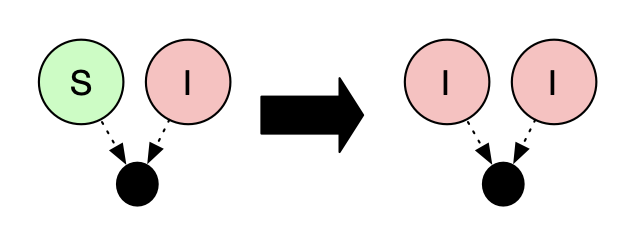

In [7]:

"""Now each token type needs a rewrite rule to move"""
function state_to_rw_rule_gr(p::LabelledPetriNet, s::Int)
  E = @acset petri_to_cset_type_gr(p) begin V=2;E=1;src=1;tgt=2 end
  x = p[s, :sname]
  Rule(map(1:2) do i
    cset = deepcopy(E)
    add_part!(cset, x; Dict(loc(x)=>i)...)
    return hom(E,cset)
  end...)
end

rw = state_to_rw_rule_gr(sir_petri, 1)
codom(rw.L) # S on position 1
dom(rw.L) # Just an edge
codom(rw.R); # S on position 2


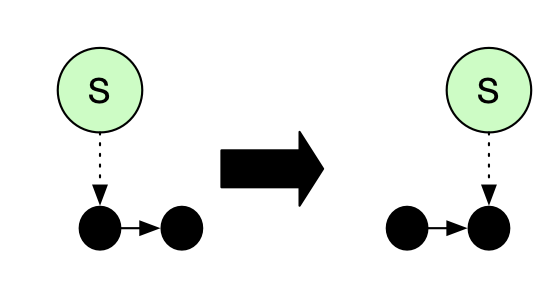

We can now use these rewrite rules on larger sytems and analyze the dynamics.
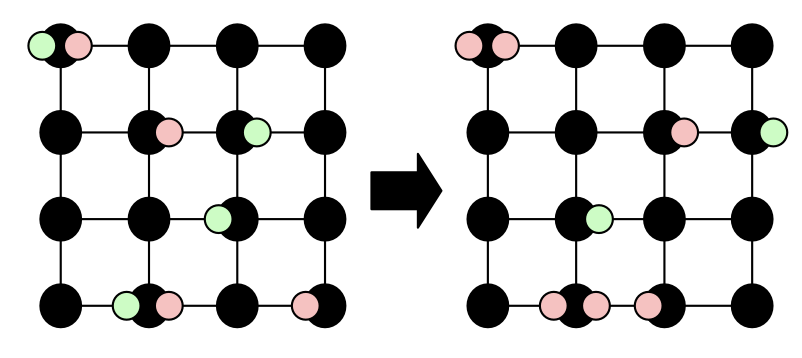